In [1]:
import pandas as pd
pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)

def load_priorband_data():
    df = pd.read_parquet("data_for_anton.parquet")
    df_formatted=pd.DataFrame(columns=["benchmark","prior","algorithm","fidelity","seed","score"])
    df=df.reset_index()
    df_collection=[]
    for seed_nr in range(50):
        partial_df=df[["benchmark","prior","algorithm","used_fidelity"]]
        partial_df["value"]=df[f"seed-{seed_nr}"]
        partial_df["seed"]=seed_nr
        df_collection.append(partial_df)
        print(f"Seed {seed_nr+1}/50", end="\r", flush=True)
    return pd.concat(df_collection,ignore_index=True)

df=load_priorband_data()

In [2]:
rs_hb_pb=["random_search","hyperband","pb_mutation_dynamic_geometric-default-at-target"]
df_dict={"all":{"all":df}}
df_dict={"all":{"RS+HB+PB":df.loc[(df["algorithm"].isin(rs_hb_pb))]}}
df_dict={"good+bad":{"all":df.loc[(df["prior"]=="good")|(df["prior"]=="bad")]}}
df_dict["good+bad"]["RS+HB+PB"]=df.loc[((df["prior"]=="good")|(df["prior"]=="bad"))&(df["algorithm"].isin(rs_hb_pb))]
for priortype in df["prior"].unique():
    df_dict[priortype]={}
    df_dict[priortype]["all"]=df.loc[df["prior"]==priortype]
    df_dict[priortype]["RS+HB+PB"]=df.loc[(df["prior"]==priortype)&((df["algorithm"].isin(rs_hb_pb)))]

In [3]:
def autorank_formatter(df:pd.DataFrame,system_id:str,metric:str,used_fidelity_min=None, used_fidelity_max:float=None,):
    if not used_fidelity_max:
        used_fidelity_max=max(df["used_fidelity"])
    if not used_fidelity_min:
        used_fidelity_min=min(df["used_fidelity"])
    df_collector=[]
    for algo in df[system_id].unique():
        algo_df=pd.DataFrame(df.loc[(df[system_id]==algo)&(df["used_fidelity"]<=used_fidelity_max)&(df["used_fidelity"]>=used_fidelity_min)][metric])
        algo_df=algo_df.rename(columns={metric:algo})
        df_collector.append(algo_df[algo].to_list())
    df_collector=list(zip(*df_collector))
    return pd.DataFrame(df_collector,columns=df[system_id].unique())

In [4]:
from autorank import autorank, create_report, plot_stats
import warnings
warnings.filterwarnings("ignore","p-value may not be accurate for N > 5000.")
from matplotlib import pyplot as plt

system_id="algorithm"
df_dict_autorank={}
for priortype in ["good+bad","good","bad"]:
    df_dict_autorank[priortype]=autorank_formatter(df_dict[priortype]["RS+HB+PB"],"algorithm","value")

# PriorBand Analysis with Autorank for all cost/time/fidelities combined/ignored
for priortype in df_dict_autorank.keys():
    print(f"Random Search vs. HyperBand vs. PriorBand on Prior: {priortype} \n")
    result=autorank(df_dict_autorank[priortype],
            alpha=0.05,
            verbose=False)
    # print(result[0])
    # plot_stats(result)
    plt.show()

Random Search vs. HyperBand vs. PriorBand on Prior: good+bad 

Random Search vs. HyperBand vs. PriorBand on Prior: good 

Random Search vs. HyperBand vs. PriorBand on Prior: bad 



In [5]:
import numpy as np
system_id="algorithm"
steps=50
min_f=1
max_f=25.2
quantiles=False
df_dict_autorank_fidelities={}
for priortype in ["good+bad","good","bad"]:
    df_dict_autorank_fidelities[priortype]={}
    if quantiles:
        linspace=np.quantile(df_dict[priortype]["RS+HB+PB"].loc[(df_dict[priortype]["RS+HB+PB"]["used_fidelity"]>=min_f)&(df_dict[priortype]["RS+HB+PB"]["used_fidelity"]<=max_f)]["used_fidelity"],np.linspace(0,1,num=steps,endpoint=True))
        for n,f in enumerate(linspace[:-1]):
            df_at_fidelity=autorank_formatter(df_dict[priortype]["RS+HB+PB"],"algorithm","value",f,linspace[n+1]) 
            passed=True
            for system in df_at_fidelity.columns:
                if len(df_at_fidelity[system])<5:
                    passed=False
            if passed:
                df_dict_autorank_fidelities[priortype][linspace[n+1]]=df_at_fidelity
    else:
        # print(df_dict[priortype]["RS+HB+PB"]["prior"].value_counts())
        for f in np.linspace(max(min_f,min(df_dict[priortype]["RS+HB+PB"]["used_fidelity"])),min(max_f,max(df_dict[priortype]["RS+HB+PB"]["used_fidelity"])),num=steps,endpoint=True):
            print(f"{priortype}, {round(f,4)}           ",end="\r",flush=True)
            
            df_dict_autorank_fidelities[priortype][f]=autorank_formatter(df_dict[priortype]["RS+HB+PB"],"algorithm","value",used_fidelity_max=f)

In [6]:

scores={}
for n_prior,priortype in enumerate(df_dict_autorank_fidelities.keys()):
    fidelities_steps=list(df_dict_autorank_fidelities[priortype].keys())
    scores[priortype]={}
    for system in df_dict_autorank_fidelities[priortype][list(df_dict_autorank_fidelities[priortype].keys())[0]].keys():
        scores[priortype][system]=[]
    for n_f,f in enumerate(fidelities_steps):
        # print(priortype,len(df_dict_autorank_fidelities[priortype][f]))
        print(f"Prior {n_prior+1}/{len(df_dict_autorank_fidelities.keys())}: Fidelity {n_f+1}/{len(fidelities_steps)}  ",end="\r",flush=True)
        result_frame=autorank(df_dict_autorank_fidelities[priortype][f],
                alpha=0.5,
                verbose=False)[0]
        for system in result_frame.index:
            scores[priortype][system].append(result_frame.loc[system,"meanrank"])

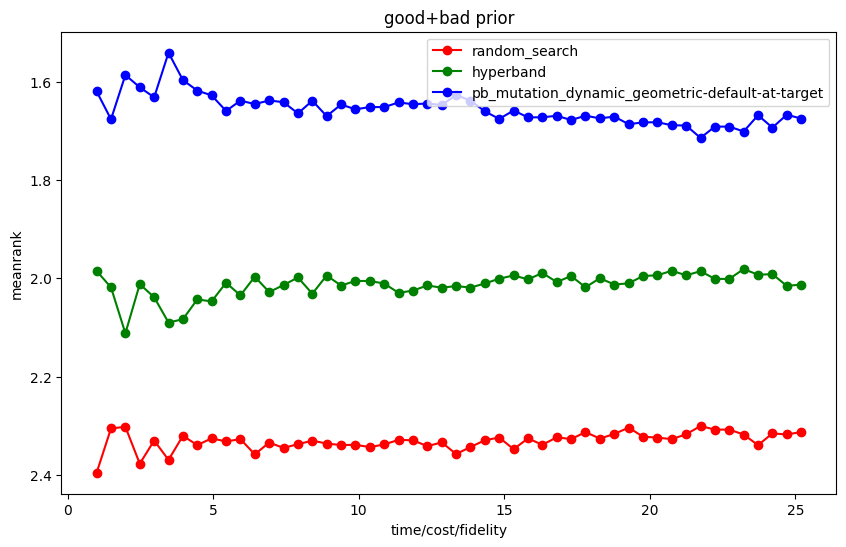

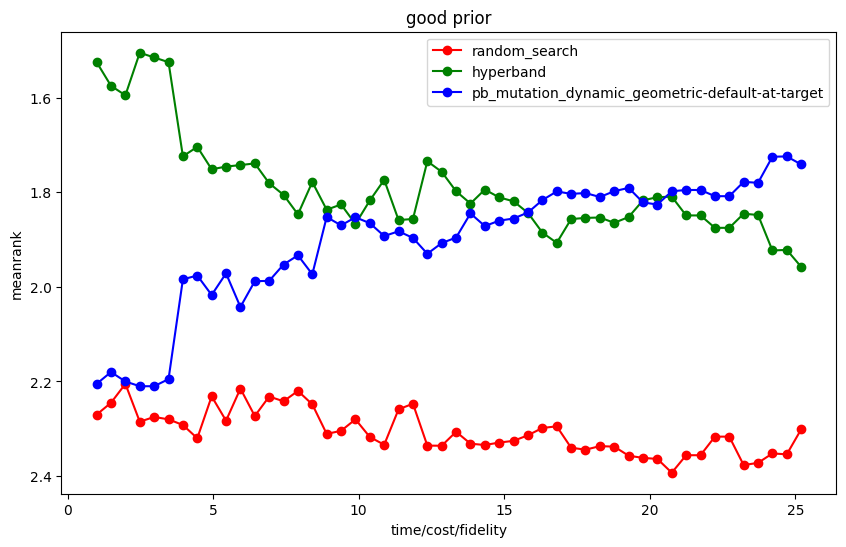

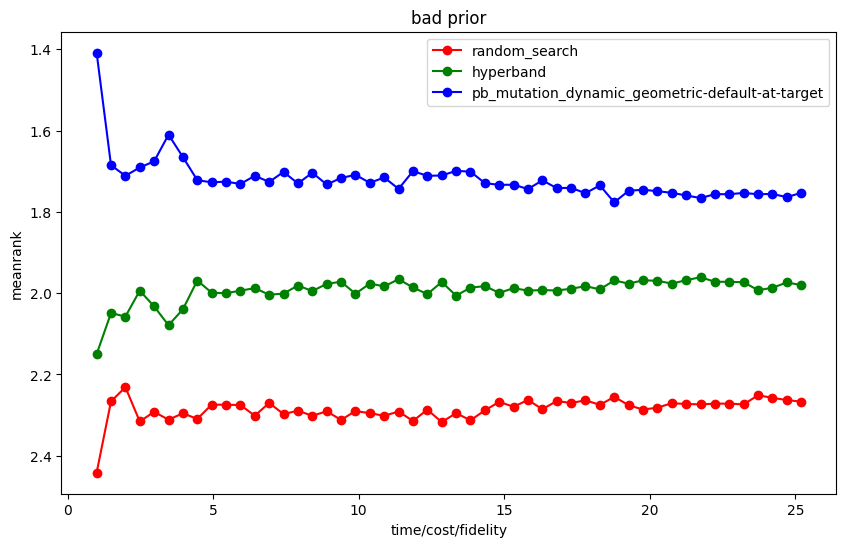

In [7]:
color_dict={"random_search":"red","hyperband":"green","pb_mutation_dynamic_geometric-default-at-target":"blue","priorband":"blue"}
for priortype in scores.keys():
    _, axis = plt.subplots(figsize=(10, 6))
    for system in scores[priortype]:
        axis.errorbar(
            fidelities_steps,
            scores[priortype][system],
            fmt="o-",
            capsize=3,
            label=system,
            color=color_dict[system]
        )
    axis.set_xlabel("time/cost/fidelity")
    axis.set_ylabel("meanrank")
    axis.set_title(f"{priortype} prior")
    axis.invert_yaxis()
    axis.legend()
plt.show()